# ROI analysis: Results
Natalia Vélez, April 2022

In [7]:
%matplotlib inline

import sys, pickle
import pandas as pd
import numpy as np
from os.path import join as opj
from pingouin import partial_corr

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

sys.path.append('..')
from utils import gsearch, print_list, str_extract
import rsatoolbox as rsa

in_dir = 'outputs/roi_rsa'

Get IDs of valid participants

In [8]:
subjects = np.loadtxt('../1_preprocessing/outputs/valid_participants.txt', dtype=int)
print(subjects)

[ 1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26
 27 28 29 30]


Unroll distances into one big dataframe

In [9]:
distance_list = []
for s in subjects:
    sub_id = f'sub-{s:02}'

    # Load behavioral RDMs
    behav_file = opj(in_dir, sub_id, f'{sub_id}_behavioral_RDM.p')
    with open(behav_file, 'rb') as f:
        behav_dict = pickle.load(f)

    # Load behavioral RDMs
    sub_rdms = {k:v.predict() for k,v in behav_dict.items()}

    # Load neuro RDMs
    neuro_files = gsearch(in_dir, sub_id, '*RDM.h5')
    roi_labels = []
    for roi_file in neuro_files:
        roi_label = str_extract('(?<=roi-)[A-Z]+', roi_file)
        roi_labels.append(roi_label)

        roi_rdm = rsa.rdm.load_rdm(roi_file) # Load neuro RDM
        sub_rdms[roi_label] = roi_rdm.dissimilarities.flatten()

    # Put everything together into a dataframe
    sub_df = pd.DataFrame(sub_rdms)
    sub_df = pd.melt(sub_df, id_vars=list(behav_dict.keys()), value_vars=roi_labels, var_name='roi', value_name='neuro').assign(subject=sub_id)
    
    distance_list.append(sub_df)
    
distance_df = pd.concat(distance_list)
print(distance_df.shape)
distance_df.head()

(1271037, 6)


,belief,time,block,roi,neuro,subject
0,0.183503,15.70,0.0,DMPFC,0.468593,sub-01
1,0.183503,74.15,1.0,DMPFC,1.174391,sub-01
2,0.183503,88.60,1.0,DMPFC,0.959533,sub-01
3,0.183503,103.30,1.0,DMPFC,0.820586,sub-01
4,0.333333,146.85,1.0,DMPFC,0.255327,sub-01


Compute partial correlations between belief and neuro RDMs, after controlling for time:

In [15]:
corr_list = []

for (sub,roi),group in distance_df.groupby(['subject', 'roi']):

#     # Method 1: partial correlation
#     roi_corr = partial_corr(data=group, x='belief', y='neuro', covar=['time', 'block'], method='spearman')
#     roi_corr['subject'] = sub
#     roi_corr['roi'] = roi

    # Method 2: Correlation
    
    cor_coeff = group[['belief', 'neuro']].corr('spearman').loc['belief', 'neuro']
    roi_corr = pd.DataFrame({'subject': [sub], 'roi': [roi], 'r': [cor_coeff]})    
    corr_list.append(roi_corr)
    
corr_df = pd.concat(corr_list)
corr_df['z'] = np.arctanh(corr_df.r)
print(corr_df.shape)
corr_df.head()

(194, 4)


,subject,roi,r,z
0,sub-01,DMPFC,-0.005772,-0.005773
0,sub-01,LTPJ,-0.016536,-0.016538
0,sub-01,MMPFC,-0.017770,-0.017772
0,sub-01,PC,-0.022896,-0.022900
0,sub-01,RSTS,-0.011241,-0.011241


In [17]:
corr_df.groupby('roi').z.mean()

roi
DMPFC    0.009835
LTPJ     0.014845
MMPFC    0.013130
PC       0.012366
RSTS     0.017649
RTPJ     0.010381
VMPFC    0.013630
Name: z, dtype: float64

Plot RSA result

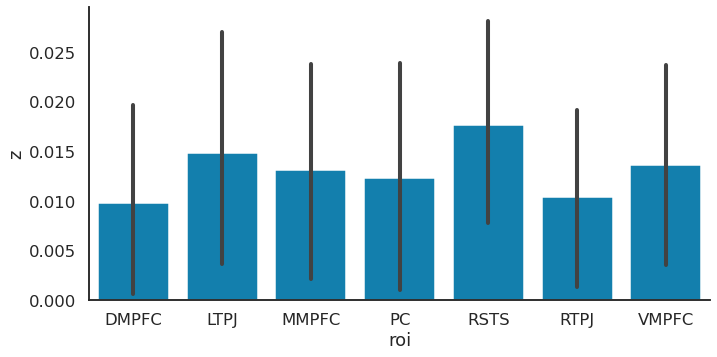

In [18]:
sns.catplot(data=corr_df, x='roi', y='z', kind='bar', aspect=2, fc='#137fad')